In [1]:
%matplotlib ipympl
#%matplotlib widget
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyobs
import bison

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [2]:
### Data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_seed123456.dat")
print(data.keys())
print(data['Configuration 40'].keys())
print(data['Configuration 40']['Q'].shape)
print(data['MC History tag-1']['dH'].shape)
print(data['MC History tag-1']['Acc/Rej'].shape)

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_seed123456.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 61.0802 MB at 108.101 MB/s
dict_keys(['beta coupling', 'Lattice', 'Number of steps of OMF4 integrator', 'Length of each MD trajectory', 'MD trajectories', 'MC measure step', 'epsilon WF', 'WF evolutions from t = 0', 'WF measure step', 'Configuration 1', 'Configuration 2', 'Configuration 3', 'Configuration 4', 'Configuration 5', 'Configuration 6', 'Configuration 7', 'Configuration 8', 'Configuration 9', 'Configuration 10', 'Configuration 11', 'Configuration 12', 'Configuration 13', 'Configuration 14', 'Configuration 15', 'Configuration 16', 'Configuration 17', 'Configuration 18', 'Configuration 19', 'Configuration 20', 'MC History tag-0', 'Configuration 21', 'Configuration 22', 'Configuration 23', 'Configuration 24', 'Configuration 25', 'Configuration 26', 'Configuration 27', 'Configuration 28', 'Configuration 29', 'Configurati

In [8]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg = 0
Nh    = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg += 1
    if key.startswith('MC History'):
        Nh += 1


print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(*(f" t = {eps_WF * WF_step * i:.2f}" for i in range(Nwf)), sep='\n')

Ntherm0 = 200
print(f"\n Total number of measurements = {Ncnfg}, extracted from {Nh} runs, {Nc_run} meas. each.")
print(f" Total number of configurations = {int(Ncnfg * tauMD * MC_step)} MDU")
print(f" Preliminary thermalization trajectories = {Ntherm0}, i.e. {int(Ntherm0 * tauMD)} MDU")
print(f" we should reach 5 x max(tau_int) [MDU], namely ~ {int(5 * MC_step * tauMD * 20)} MDU")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 t = 0.00
 t = 0.10
 t = 0.20
 t = 0.30
 t = 0.40
 t = 0.50
 t = 0.60
 t = 0.70
 t = 0.80
 t = 0.90
 t = 1.00
 t = 1.10
 t = 1.20
 t = 1.30
 t = 1.40
 t = 1.50
 t = 1.60
 t = 1.70
 t = 1.80
 t = 1.90
 t = 2.00
 t = 2.10
 t = 2.20
 t = 2.30
 t = 2.40
 t = 2.50
 t = 2.60
 t = 2.70
 t = 2.80
 t = 2.90
 t = 3.00
 t = 3.10
 t = 3.20
 t = 3.30
 t = 3.40
 t = 3.50
 t = 3.60
 t = 3.70
 t = 3.80
 t = 3.90
 t = 4.00
 t = 4.10
 t = 4.20
 t = 4.30
 t = 4.40
 t = 4.50
 t = 4.60
 t = 4.70
 t = 4.80
 t = 4.90
 t = 5.00
 t = 5.10
 t = 5.20
 t = 5.30
 t = 5.40
 t = 5.50
 t = 5.60
 t = 5.70
 t = 5.80
 t = 5.90
 t = 6.00

 Total number of 

In [13]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg, Nwf, T))
WF_Q     = np.zeros((Ncnfg, Nwf, T))
Acc      = np.zeros((Nh * Ntraj)) 
dH       = np.zeros((Nh * Ntraj))

for i in range(Ncnfg):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q'] 

for i in range(Nh):
    Acc[i*Ntraj:(i+1)*Ntraj] = data[f'MC History tag-{i}']['Acc/Rej']
    dH[i*Ntraj:(i+1)*Ntraj]  = data[f'MC History tag-{i}']['dH']

print(f"\n Acceptance rate        =  {np.mean(Acc)*100:.0f} %")
print(f" < |dH| >               =  {np.mean(np.abs(dH)):.3e}\n")


 Acceptance rate        =  94 %
 < |dH| >               =  1.084e-01



In [14]:
print(f" We need to reach a number of thermalization MD trajectories which is : 5 x max(tau_int) x MC_step = {5 * 20 * MC_step}")
print(f" {Ntherm0} traj. have already been done, so we skip {5 * 20 * MC_step - Ntherm0} traj. in the current initial data.")
print(f" In other words we have to skip {(5 * 20 * MC_step - Ntherm0) // MC_step} measurements.")
skip = (5 * 20 * MC_step - Ntherm0) // MC_step

 We need to reach a number of thermalization MD trajectories which is : 5 x max(tau_int) x MC_step = 1000
 200 traj. have already been done, so we skip 800 traj. in the current initial data.
 In other words we have to skip 80 measurements.


In [15]:
### Compute <E_Clov>_t and tau_int ###
t_WF = np.array([eps_WF * WF_step * i for i in range(Nwf)])
obsEClov = pyobs.observable(description=f'Energy Density at several WF times')
obsEClov.create('Ensemble A', np.sum(WF_EClov[skip:,:,:], axis=2).flatten(), shape=(Nwf,)) 
obsEClov /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <E_Clov> = {obsEClov[i]}                 tau_int = {obsEClov[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEClov[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <E_Clov> = 1.955329(24)
                 tau_int = 0.655 +- 0.107

(t = 0.10) :    <E_Clov> = 1.373116(36)
                 tau_int = 0.730 +- 0.133

(t = 0.20) :    <E_Clov> = 0.859956(40)
                 tau_int = 0.876 +- 0.160

(t = 0.30) :    <E_Clov> = 0.548228(44)
                 tau_int = 1.278 +- 0.276

(t = 0.40) :    <E_Clov> = 0.371007(44)
                 tau_int = 1.643 +- 0.402

(t = 0.50) :    <E_Clov> = 0.266802(44)
                 tau_int = 1.977 +- 0.511

(t = 0.60) :    <E_Clov> = 0.201879(43)
                 tau_int = 2.280 +- 0.618

(t = 0.70) :    <E_Clov> = 0.159050(42)
                 tau_int = 2.570 +- 0.727

(t = 0.80) :    <E_Clov> = 0.129356(42)
                 tau_int = 2.865 +- 0.843

(t = 0.90) :    <E_Clov> = 0.107897(42)
                 tau_int = 3.144 +- 0.961

(t = 1.00) :    <E_Clov> = 0.091850(41)
                 tau_int = 3.334 +- 1.054

(t = 1.10) :    <E_Clov> = 0.079505(40)
                 tau_int = 3.477 +- 1.136

(t =

In [16]:
### Compute <Plaq>_t, <E_Plaq>_t and tau_int ###
obsPlaq = pyobs.observable(description=f'Plaquette at several WF times')
obsPlaq.create('Ensemble A', np.sum(WF_Plaq[skip:,:,:], axis=2).flatten(), shape=(Nwf,))
obsPlaq /= V
obsEPlaq = beta * (1.0 - obsPlaq) * D * (D-1) / 2

print(*(f"(t = {t_WF[i]:.2f}) :     <E_Plaq> = {obsEPlaq[i]}                  tau_int = {obsEPlaq[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEPlaq[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :     <E_Plaq> = 14.40572(15)
                  tau_int = 0.618 +- 0.101

(t = 0.10) :     <E_Plaq> = 6.05405(13)
                  tau_int = 0.651 +- 0.106

(t = 0.20) :     <E_Plaq> = 2.619988(95)
                  tau_int = 0.707 +- 0.129

(t = 0.30) :     <E_Plaq> = 1.279869(73)
                  tau_int = 0.872 +- 0.159

(t = 0.40) :     <E_Plaq> = 0.713749(66)
                  tau_int = 1.301 +- 0.281

(t = 0.50) :     <E_Plaq> = 0.446653(59)
                  tau_int = 1.678 +- 0.411

(t = 0.60) :     <E_Plaq> = 0.306154(55)
                  tau_int = 2.023 +- 0.522

(t = 0.70) :     <E_Plaq> = 0.224804(52)
                  tau_int = 2.325 +- 0.630

(t = 0.80) :     <E_Plaq> = 0.173771(51)
                  tau_int = 2.693 +- 0.793

(t = 0.90) :     <E_Plaq> = 0.139605(49)
                  tau_int = 3.001 +- 0.917

(t = 1.00) :     <E_Plaq> = 0.115510(48)
                  tau_int = 3.211 +- 1.016

(t = 1.10) :     <E_Plaq> = 0.097797(47)
                  tau_int

In [17]:
### Compute <Q>_t and tau_int ###
obsQ = pyobs.observable(description=f'Topological charge at several WF times')
obsQ.create('Ensemble A', np.sum(WF_Q[skip:,:,:], axis=2).flatten(), shape=(Nwf,)) 
obsQ /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <Q> = {obsQ[i]}                 tau_int = {obsQ[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q> = 0.07(29)
                 tau_int = 0.609 +- 0.100

(t = 0.10) :    <Q> = -0.43(48)
                 tau_int = 2.859 +- 0.842

(t = 0.20) :    <Q> = -0.81(92)
                 tau_int = 12.456 +- 6.432

(t = 0.30) :    <Q> = -1.0(1.2)
                 tau_int = 17.216 +- 9.840

(t = 0.40) :    <Q> = -1.2(1.3)
                 tau_int = 18.908 +- 11.133

(t = 0.50) :    <Q> = -1.3(1.4)
                 tau_int = 19.517 +- 11.601

(t = 0.60) :    <Q> = -1.3(1.5)
                 tau_int = 19.846 +- 11.908

(t = 0.70) :    <Q> = -1.4(1.5)
                 tau_int = 19.952 +- 11.971

(t = 0.80) :    <Q> = -1.4(1.6)
                 tau_int = 20.011 +- 12.007

(t = 0.90) :    <Q> = -1.4(1.6)
                 tau_int = 20.044 +- 12.026

(t = 1.00) :    <Q> = -1.5(1.6)
                 tau_int = 20.062 +- 12.037

(t = 1.10) :    <Q> = -1.5(1.6)
                 tau_int = 20.073 +- 12.044

(t = 1.20) :    <Q> = -1.5(1.6)
                 tau_int = 20.080 +- 12.048

(t = 1

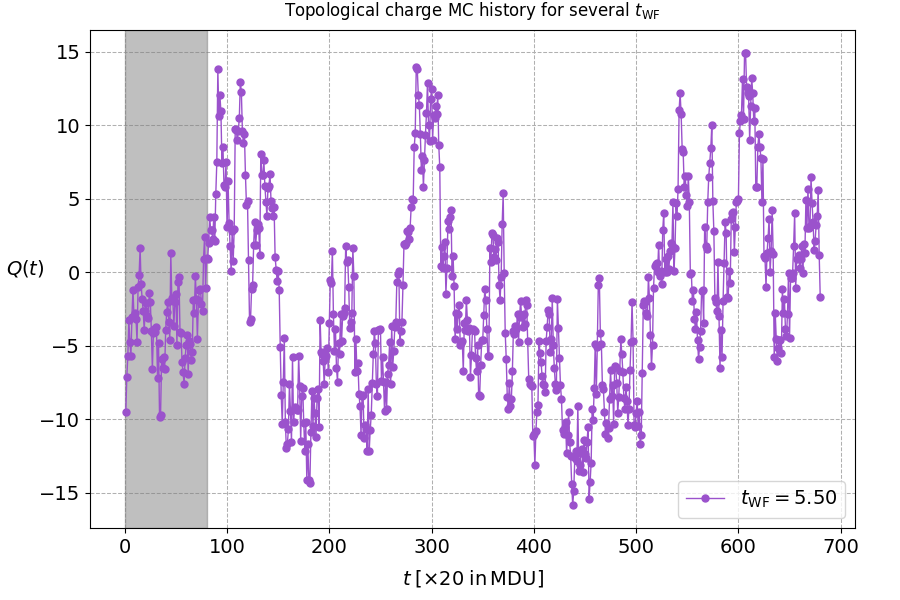

In [21]:
### MC history of Q for several tWF ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(f"Topological charge MC history for several $t_{{\mathrm{{WF}}}}$", pad=10)
ax.set_ylabel(r"$Q(t)$", labelpad=10, rotation=0, fontsize=fsize)
ax.set_xlabel(rf'$t \; [\times {int(MC_step * tauMD)} \; \mathrm{{in \, MDU}}]$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

tWF = np.array([1.50, 3.50, 5.50])
i0  = (tWF / (eps_WF * WF_step)).astype(int)
# ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[:, i0[0], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[0]}$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
# ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[:, i0[1], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[1]:.2f}$', linestyle='-', marker='o' , markersize=5.0, color='#2bad4e', linewidth=1.0)
ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[:, i0[2], :], axis=1)/V, label=rf'$t_{{\mathrm{{WF}}}} = {tWF[2]:.2f}$', linestyle='-', marker='o' , markersize=5.0, color='#9b52cc', linewidth=1.0)

ax.axvspan(0.0, skip, alpha=0.5, color='#808080')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [22]:
### Compute <Q^2>_t and tau_int ###
obsQ2 = pyobs.observable(description=f'Topological susceptibility at several WF times')
obsQ2.create('Ensemble A', ((np.sum(WF_Q[skip:,:,:], axis=2))**2).flatten(), shape=(Nwf,))
obsQ2 /= V**2

print(*(f"(t = {t_WF[i]:.2f}) :    <Q^2> = {obsQ2[i]}                 tau_int = {obsQ2[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ2[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q^2> = 41.0(2.3)
                 tau_int = 0.475 +- 0.067

(t = 0.10) :    <Q^2> = 23.9(1.3)
                 tau_int = 0.552 +- 0.090

(t = 0.20) :    <Q^2> = 21.2(1.9)
                 tau_int = 1.663 +- 0.407

(t = 0.30) :    <Q^2> = 25.0(3.2)
                 tau_int = 3.606 +- 1.178

(t = 0.40) :    <Q^2> = 29.3(4.3)
                 tau_int = 5.159 +- 1.930

(t = 0.50) :    <Q^2> = 32.8(5.1)
                 tau_int = 5.895 +- 2.308

(t = 0.60) :    <Q^2> = 35.3(5.6)
                 tau_int = 6.210 +- 2.484

(t = 0.70) :    <Q^2> = 37.1(5.9)
                 tau_int = 6.346 +- 2.591

(t = 0.80) :    <Q^2> = 38.5(6.2)
                 tau_int = 6.470 +- 2.642

(t = 0.90) :    <Q^2> = 39.6(6.4)
                 tau_int = 6.552 +- 2.675

(t = 1.00) :    <Q^2> = 40.5(6.5)
                 tau_int = 6.604 +- 2.696

(t = 1.10) :    <Q^2> = 41.2(6.7)
                 tau_int = 6.635 +- 2.709

(t = 1.20) :    <Q^2> = 41.8(6.7)
                 tau_int = 6.587 +- 2.743


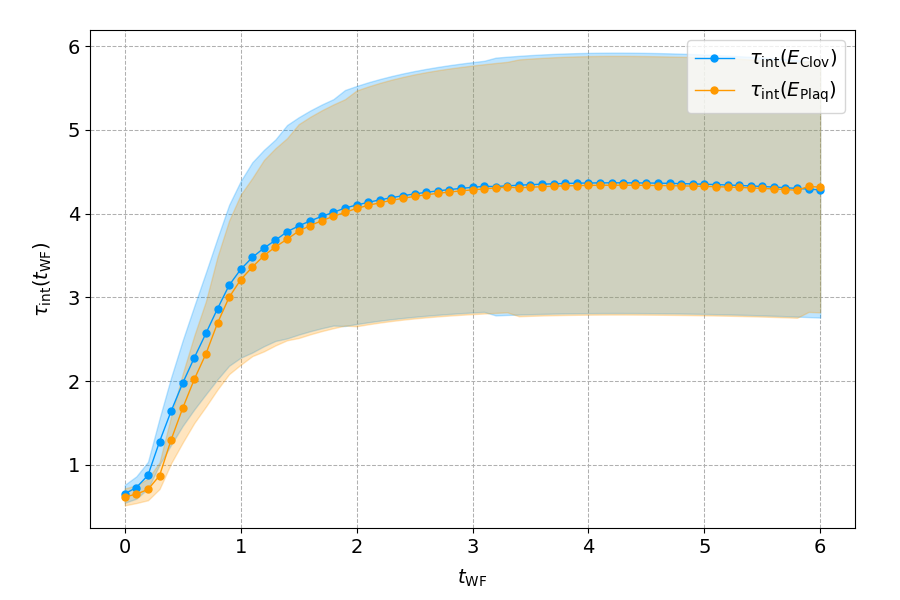

In [23]:
tau_EClov = np.array([np.squeeze(obsEClov[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_EPlaq = np.array([np.squeeze(obsEPlaq[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_Q     = np.array([np.squeeze(obsQ[i].tauint()['Ensemble A'],     axis=1) for i in range(Nwf)])
tau_Q2    = np.array([np.squeeze(obsQ2[i].tauint()['Ensemble A'],    axis=1) for i in range(Nwf)])


fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_ylabel(r"$\tau_\mathrm{int}(t_\mathrm{WF})$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(t_WF, tau_EClov[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Clov})$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF, tau_EClov[:,0] + std * tau_EClov[:,1], tau_EClov[:,0] - std * tau_EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF, tau_EPlaq[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Plaq})$', linestyle='-', marker='o' , markersize=5.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF, tau_EPlaq[:,0] + std * tau_EPlaq[:,1], tau_EPlaq[:,0] - std * tau_EPlaq[:,1], alpha=.25, color='#ff9900')
# ax.plot(t_WF, tau_Q[:,0], label=r'$\tau_\mathrm{int}(Q)$', linestyle='-', marker='o' , markersize=5.0, color='#a151bf', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q[:,0] + std * tau_Q[:,1], tau_Q[:,0] - std * tau_Q[:,1], alpha=.25, color='#a151bf')
# ax.plot(t_WF, tau_Q2[:,0], label=r'$\tau_\mathrm{int}(Q^2)$', linestyle='-', marker='o' , markersize=5.0, color='#d13e27', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q2[:,0] + std * tau_Q2[:,1], tau_Q2[:,0] - std * tau_Q2[:,1], alpha=.25, color='#d13e27')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [24]:
### Compute t^2<E> for each t_WF ###
obs_t2EClov = (t_WF[1:]**2) * obsEClov[1:]
obs_t2EPlaq = (t_WF[1:]**2) * obsEPlaq[1:]
print("\n")
print(*(f"(t = {t_WF[i+1]:.2f}) :   t^2 <E_Clov> = {obs_t2EClov[i]}               t^2 <E_Plaq> = {obs_t2EPlaq[i]}\n" for i in range(WF_evol // WF_step)), sep='')



(t = 0.10) :   t^2 <E_Clov> = 0.01373116(36)
               t^2 <E_Plaq> = 0.0605405(13)

(t = 0.20) :   t^2 <E_Clov> = 0.0343982(16)
               t^2 <E_Plaq> = 0.1047995(38)

(t = 0.30) :   t^2 <E_Clov> = 0.0493405(40)
               t^2 <E_Plaq> = 0.1151882(66)

(t = 0.40) :   t^2 <E_Clov> = 0.0593611(71)
               t^2 <E_Plaq> = 0.114200(11)

(t = 0.50) :   t^2 <E_Clov> = 0.066701(11)
               t^2 <E_Plaq> = 0.111663(15)

(t = 0.60) :   t^2 <E_Clov> = 0.072677(15)
               t^2 <E_Plaq> = 0.110215(20)

(t = 0.70) :   t^2 <E_Clov> = 0.077934(21)
               t^2 <E_Plaq> = 0.110154(25)

(t = 0.80) :   t^2 <E_Clov> = 0.082788(27)
               t^2 <E_Plaq> = 0.111213(32)

(t = 0.90) :   t^2 <E_Clov> = 0.087397(34)
               t^2 <E_Plaq> = 0.113080(40)

(t = 1.00) :   t^2 <E_Clov> = 0.091850(41)
               t^2 <E_Plaq> = 0.115510(48)

(t = 1.10) :   t^2 <E_Clov> = 0.096201(49)
               t^2 <E_Plaq> = 0.118335(56)

(t = 1.20) :   t^2 <E_Clov> = 0.1

In [25]:
### Calculation of t_0 for both E_Clov and E_Plaq ###
eps = 0.008

x, dx = obs_t2EClov.error()
idx_x = np.squeeze(np.where((x < 0.3 + eps) & (x > 0.3 - eps)), axis=0)
print(f"\nE_Clov  :")
print(f"                  E_Clov  =  {x[idx_x]},") 
print(f"                  t_WF    =  {t_WF[idx_x+1]},\n") # recall t_WF starts from 0.0, whose corresponding value is not neither in obs_t2EClov nor in obs_t2EPlaq.
interp_Clov = pyobs.interpolate(t_WF[idx_x+1], obs_t2EClov[idx_x])
obs_t0EClov = interp_Clov.solve(0.3, bracket=[t_WF[(idx_x+1)[0]], t_WF[(idx_x+1)[-1]]])
print(f"                  interpolation  --->  t0 = {obs_t0EClov}")
t0_EClov, dt0_EClov = np.squeeze(obs_t0EClov.error(), axis=1)

y, dy = obs_t2EPlaq.error()
idx_y = np.squeeze(np.where((y < 0.3 + eps) & (y > 0.3 - eps)), axis=0)
print(f"E_Plaq  :")
print(f"                  E_Plaq  =  {y[idx_y]},") 
print(f"                  t_WF    =  {t_WF[idx_y+1]},\n")
interp_Plaq = pyobs.interpolate(t_WF[idx_y+1], obs_t2EPlaq[idx_y])
obs_t0EPlaq = interp_Plaq.solve(0.3, bracket=[t_WF[(idx_y+1)[0]], t_WF[(idx_y+1)[-1]]])
print(f"                  interpolation  --->  t0 = {obs_t0EPlaq}")
t0_EPlaq, dt0_EPlaq = np.squeeze(obs_t0EPlaq.error(), axis=1)


E_Clov  :
                  E_Clov  =  [0.29414514 0.29939299 0.30467094],
                  t_WF    =  [5.4 5.5 5.6],

                  interpolation  --->  t0 = 5.512(15)

E_Plaq  :
                  E_Plaq  =  [0.29266339 0.29797478 0.30332057],
                  t_WF    =  [5.  5.1 5.2],

                  interpolation  --->  t0 = 5.138(14)



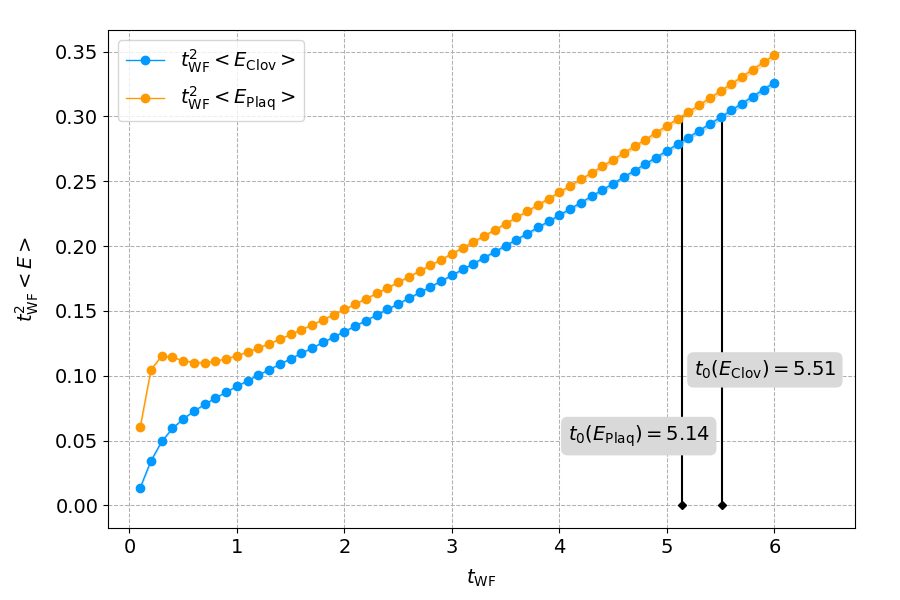

In [26]:
t2EClov = np.array([np.squeeze(obs_t2EClov[i].error(), axis=1) for i in range(WF_evol // WF_step)])
t2EPlaq = np.array([np.squeeze(obs_t2EPlaq[i].error(), axis=1) for i in range(WF_evol // WF_step)])

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

fsize = 14
std = 2.0
box = dict(boxstyle="round", color='#d9d9d9')

ax.set_ylabel(r"$t_\mathrm{WF}^2 <E>$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

ax.vlines(x = t0_EClov, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EClov, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EClov, 0.0, xerr=std*dt0_EClov, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Clov}}) = {t0_EClov:.2f}$", (t0_EClov, 0.10), xytext=(t0_EClov+0.4, 0.10), ha='center', bbox=box, fontsize=fsize)
ax.vlines(x = t0_EPlaq, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EPlaq, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EPlaq, 0.0, xerr=std*dt0_EPlaq, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Plaq}}) = {t0_EPlaq:.2f}$", (t0_EPlaq, 0.10), xytext=(t0_EPlaq-0.4, 0.05), ha='center', bbox=box, fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.2, 6.75])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.plot(t_WF[1:], t2EClov[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Clov}>$', linestyle='-', marker='o' , markersize=6.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EClov[:,0] + std * t2EClov[:,1], t2EClov[:,0] - std * t2EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF[1:], t2EPlaq[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Plaq}>$', linestyle='-', marker='o' , markersize=6.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EPlaq[:,0] + std * t2EPlaq[:,1], t2EPlaq[:,0] - std * t2EPlaq[:,1], alpha=.25, color='#ff9900')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig('t0E.pdf')

In [27]:
### Compute correlator <q(t)q(0)> for a given tWF. ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
QQ = np.zeros((Ncnfg, T))
for tp in range(T):
    QQ[:,tp] = np.mean(WF_Q[:,i0,:] * np.roll(WF_Q[:,i0,:], -tp, axis=1), axis=1) 

obsCorr_QQ = pyobs.observable(description=f'Correlator <q(t)q(0)> for tWF = {t0}')
obsCorr_QQ.create('Ensemble A', QQ[skip:,:].flatten(), shape=(T,))
obsCorr_QQ /= (V*T**2)
#obsCorr_QQ -= V*pyobs.tile(obsQ[i0], T)
print(obsCorr_QQ)
print(obsQ[i0])

47.2(2.0)	44.0(1.9)	35.8(1.8)	25.9(1.7)	16.8(1.6)	9.8(1.6)	5.1(1.5)	2.3(1.4)	0.9(1.4)	0.4(1.3)	0.4(1.2)	0.5(1.2)	0.7(1.1)	0.9(1.1)	1.1(1.2)	1.2(1.2)	1.4(1.3)	1.7(1.3)	2.0(1.3)	2.4(1.2)	2.8(1.2)	3.1(1.2)	3.0(1.3)	2.7(1.4)	2.2(1.4)	1.5(1.5)	0.8(1.6)	0.2(1.7)	-0.2(1.8)	-0.4(2.0)	-0.5(2.2)	-0.5(2.3)	-0.5(2.4)	-0.5(2.3)	-0.5(2.2)	-0.4(2.0)	-0.2(1.8)	0.2(1.7)	0.8(1.6)	1.5(1.5)	2.2(1.4)	2.7(1.4)	3.0(1.3)	3.1(1.2)	2.8(1.2)	2.4(1.2)	2.0(1.3)	1.7(1.3)	1.4(1.3)	1.2(1.2)	1.1(1.2)	0.9(1.1)	0.7(1.1)	0.5(1.2)	0.4(1.2)	0.4(1.3)	0.9(1.4)	2.3(1.4)	5.1(1.5)	9.8(1.6)	16.8(1.6)	25.9(1.7)	35.8(1.8)	44.0(1.9)

-1.6(1.7)



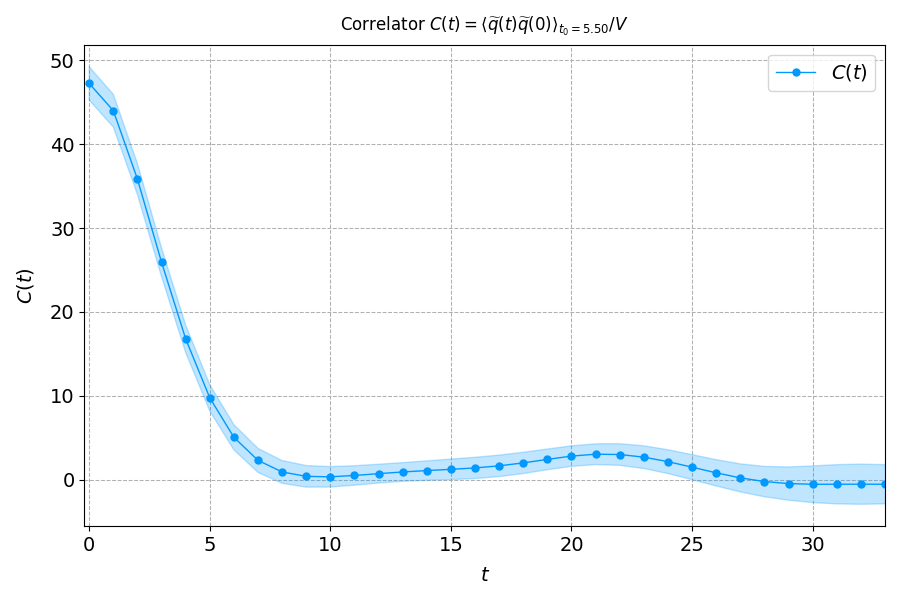

In [28]:
Ct, dCt = obsCorr_QQ.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \langle \widetilde{{q}}(t) \widetilde{{q}}(0) \rangle_{{t_0 = {t0:.2f}}} / V$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [29]:
Tsym = T // 2

obsChi_sum  = 0
Chi_sum     = np.zeros((2, Tsym + 1)) # error and central value

Chi_sum[0, 0]  = obsCorr_QQ[0].error()[0][0]
Chi_sum[1, 0]  = obsCorr_QQ[0].error()[1][0]
for t in range(1, Tsym + 1):
    obsChi_sum  += 2.0 * obsCorr_QQ[t]
    Chi_sum[0, t] = obsChi_sum.error()[0][0]
    Chi_sum[1, t] = obsChi_sum.error()[1][0]

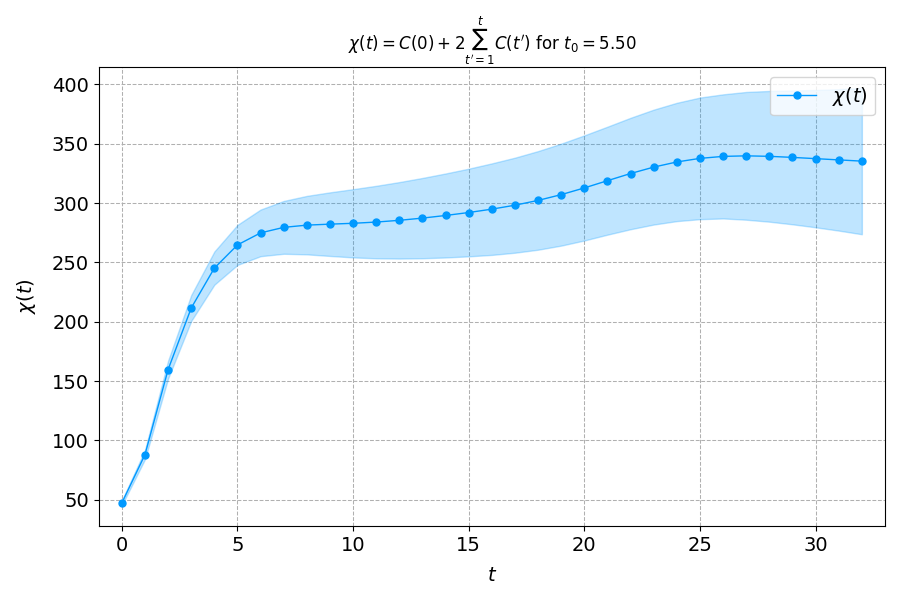

In [30]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"$\chi(t) = C(0) + 2\sum_{{t'=1}}^t C(t')$ for $t_0 = {t0:.2f}$")
ax.set_ylabel(r"$\chi(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-1, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tsym + 1), Chi_sum[0], label=r'$\chi(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tsym + 1), Chi_sum[0] + std * Chi_sum[1], Chi_sum[0] - std * Chi_sum[1], alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [31]:
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
EEClov = np.zeros((Ncnfg, T))
for tp in range(T):
    EEClov[:,tp] = np.mean(WF_EClov[:,i0,:] * np.roll(WF_EClov[:,i0,:], -tp, axis=1), axis=1)

obsCorr_EEClov = pyobs.observable(description=f'Correlator <E(t)E(0)> for tWF = {t0}')
obsCorr_EEClov.create('Ensemble A', EEClov[skip:,:].flatten(), shape=(T,))
obsCorr_EEClov *= T/V 
obsCorr_EEClov -= pyobs.tile(obsEClov[i0]*obsEClov[i0], T) * V / T
# print(obsCorr_EEClov)
# print(obsEClov[i0]*obsEClov[i0]*V/T)

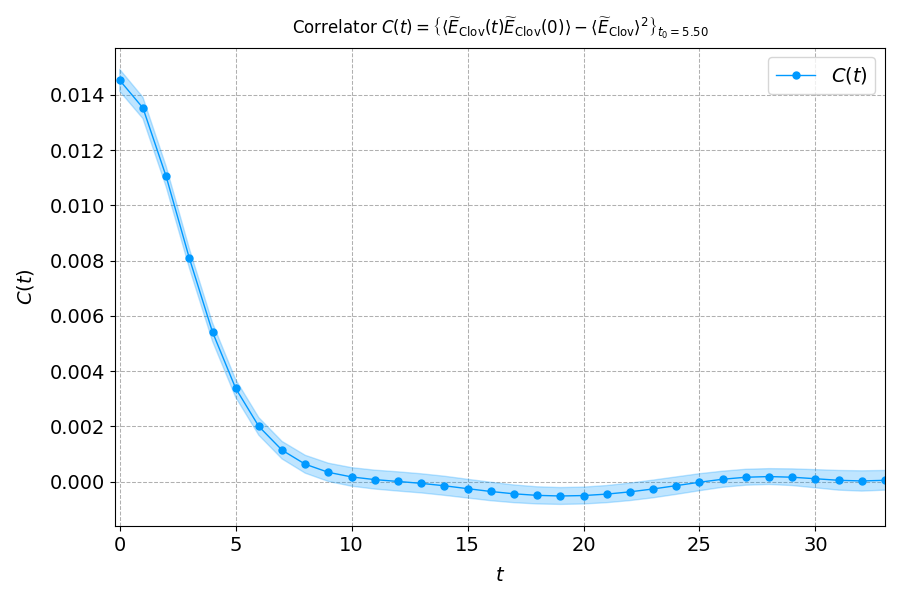

In [32]:
Ct, dCt = obsCorr_EEClov.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \left \{{ \langle \widetilde{{E}}_\mathrm{{Clov}}(t) \widetilde{{E}}_\mathrm{{Clov}}(0) \rangle - \langle \widetilde{{E}}_\mathrm{{Clov}} \rangle^2 \right \}}_{{t_0 = {t0:.2f}}}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)
#ax.set_yscale('log')

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [33]:
Tmin = 0
Tmax = T // 2
Ct_mass   = np.zeros(Tmax - Tmin)
dCt_mass  = np.zeros(Tmax - Tmin)

for i in range(Tmax - Tmin):
    eff_mass  = pyobs.log(obsCorr_EEClov[i] / obsCorr_EEClov[i+1])
    Ct_mass[i]   = eff_mass.error()[0][0]
    dCt_mass[i]  = eff_mass.error()[1][0]

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)


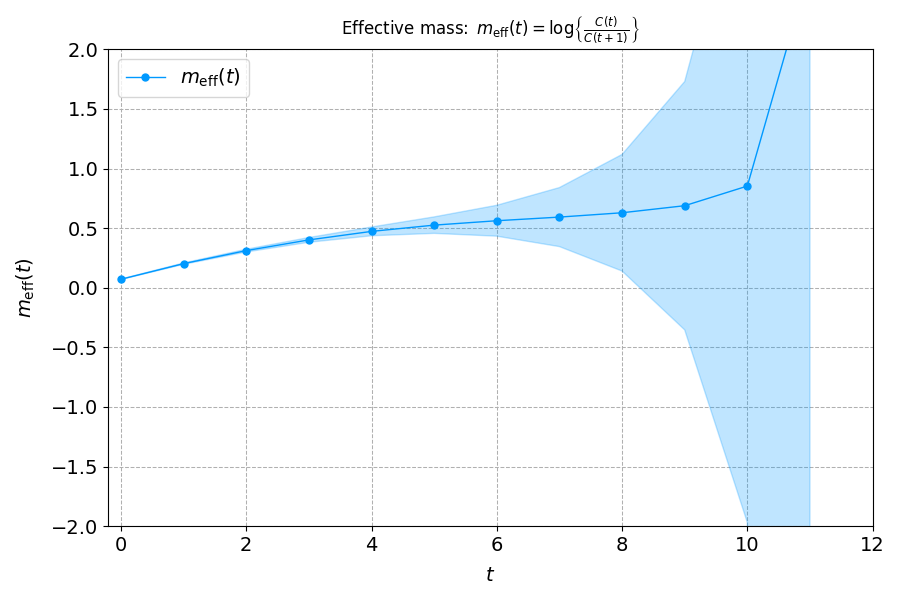

In [35]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Effective mass: $\,m_\mathrm{{eff}}(t) = \log \left \{{ \frac{{C(t)}}{{C(t+1)}} \right \}}$", pad=10)
ax.set_ylabel(r"$m_{\mathrm{eff}}(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, 12])
plt.ylim([-2, 2])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tmin, Tmax), Ct_mass, label=r'$m_{\mathrm{eff}}(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tmin, Tmax), Ct_mass + std * dCt_mass, Ct_mass - std * dCt_mass, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [36]:
### Compute autocorrelation functions for each <E_Clov>_t and <E_Plaq>_t ###
gammaEClov = []
gammaEPlaq = []
gammaQ     = []
gammaQ2    = []
if (obsEClov.shape[0] == Nwf) and (obsEPlaq.shape[0] == Nwf) \
    and (obsQ.shape[0] == Nwf) and (obsQ2.shape[0] == Nwf):
    for i in range(Nwf): 
        norm, gamma = obsEClov[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEClov.append(gamma)
        norm, gamma = obsEPlaq[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEPlaq.append(gamma)
        norm, gamma = obsQ[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ.append(gamma)
        norm, gamma = obsQ2[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ2.append(gamma)
else:
    print(f"Check observables shapes !")

norm, gamma_t0EClov = obs_t0EClov.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EClov = gamma_t0EClov / norm 

norm, gamma_t0EPlaq = obs_t0EPlaq.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EPlaq = gamma_t0EPlaq / norm 

gammaEClov = np.array(gammaEClov)
gammaEPlaq = np.array(gammaEPlaq)
gammaQ     = np.array(gammaQ)
gammaQ2    = np.array(gammaQ2)

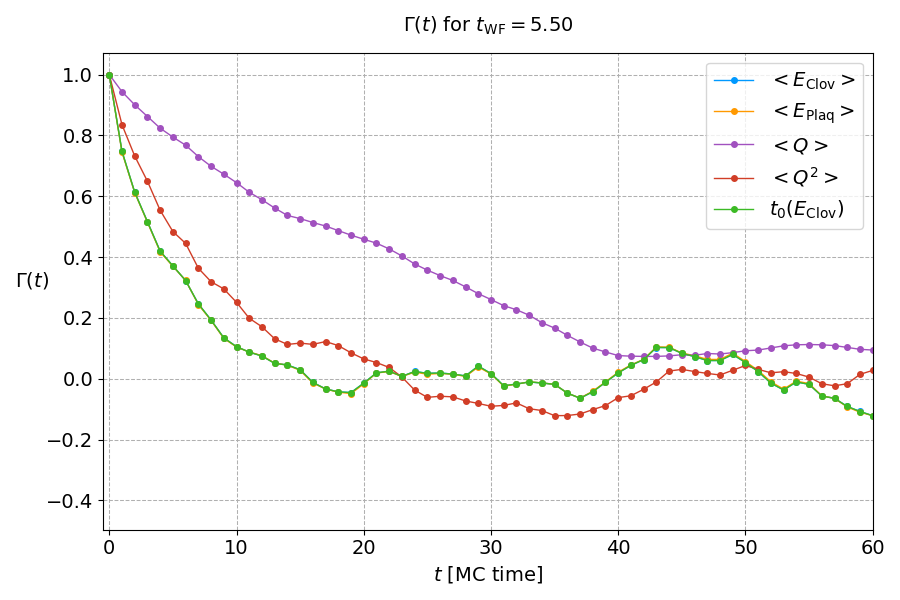

In [37]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)
fsize = 14

tmax = Ncnfg // 4
t = 5.50
i = int(t / (eps_WF * WF_step)) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.plot(np.arange(tmax), gammaEClov[i,:tmax]/gammaEClov[i,0], color='#0099ff', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Clov}}>$')
ax.plot(np.arange(tmax), gammaEPlaq[i,:tmax]/gammaEPlaq[i,0], color='#ff9900', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Plaq}}>$')
ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q>$')
ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q^2>$')
ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
ax.set_xlabel(r'$t$ [MC time]', fontsize=fsize)
ax.set_ylabel(r'$\Gamma(t)$', rotation=0, labelpad=10, fontsize=fsize)
ax.legend(loc='best', fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.5, 60])
#plt.ylim([1e-2, 1e1])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log', base=10)
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

Bounding Method application

In [38]:
### Bounding Method ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
tau0 = obsQ[i0].tauint()['Ensemble A'][0][0]
print(f"\n tau_slow for bounding = {tau0:.2f}, which is {int(tau0 * tauMD * MC_step)} MDU\n")

Tmax = 40
for t in range(Tmax):
   # print(f" t0     :    tau_eff(W={t}) = {1.0 / np.log(gamma_t0EClov[t] / gamma_t0EClov[t+1]):.3f},")
   print(f" Q      :    tau_eff(W={t}) = {1.0 / np.log(gammaQ[i0, t] / gammaQ[i0, t+1]):.3f},")
   # print(f" Q^2   :    tau_eff(W={t}) = {1.0 / np.log(gammaQ2[i0, t] / gammaQ2[i0, t+1]):.3f},")
print("\n")


 tau_slow for bounding = 19.88, which is 397 MDU

 Q      :    tau_eff(W=0) = 17.177,
 Q      :    tau_eff(W=1) = 21.395,
 Q      :    tau_eff(W=2) = 22.860,
 Q      :    tau_eff(W=3) = 22.058,
 Q      :    tau_eff(W=4) = 27.667,
 Q      :    tau_eff(W=5) = 29.392,
 Q      :    tau_eff(W=6) = 19.909,
 Q      :    tau_eff(W=7) = 22.430,
 Q      :    tau_eff(W=8) = 26.421,
 Q      :    tau_eff(W=9) = 23.700,
 Q      :    tau_eff(W=10) = 19.883,
 Q      :    tau_eff(W=11) = 24.435,
 Q      :    tau_eff(W=12) = 20.988,
 Q      :    tau_eff(W=13) = 22.653,
 Q      :    tau_eff(W=14) = 51.084,
 Q      :    tau_eff(W=15) = 40.502,
 Q      :    tau_eff(W=16) = 43.688,
 Q      :    tau_eff(W=17) = 33.161,
 Q      :    tau_eff(W=18) = 31.880,
 Q      :    tau_eff(W=19) = 34.621,
 Q      :    tau_eff(W=20) = 34.957,
 Q      :    tau_eff(W=21) = 23.083,
 Q      :    tau_eff(W=22) = 17.988,
 Q      :    tau_eff(W=23) = 14.784,
 Q      :    tau_eff(W=24) = 18.119,
 Q      :    tau_eff(W=25) = 19.44

In [39]:
def Cbar_W(gamma, W):
    """ returns Cbar(W) = gamma(0) + 2*sum_i=1^W gamma(i) """
    return gamma[0] + 2.0 * np.sum(gamma[1:W+1])

def sys_err(gammaW, W, tau_slow, tau_effW):
    """ returns the systematic effect coming from the truncation 
    of the sum of the autocorrelation function up to a window W. 
    This quantity is computed in a data-driven way, i.e. the error is 
    is given by a difference between the bounds (see eqs 4.2.1 master thesis),
    namely
        2*sum_{i=W+1}^infty{ gamma_upp(t|W, tau0) - gamma_low(t|W, tau_eff^W) }
    """
    cutoff_low = int(np.ceil(3.0 * tau_effW * np.log(10)))
    cutoff_upp = int(np.ceil(3.0 * tau_slow * np.log(10)))
    if cutoff_upp < W:
        cutoff_upp *= 2
    if cutoff_low < W:
        cutoff_low *= 2
    sum_upp = np.sum(np.exp(- (np.arange(cutoff_upp - W) + 1) / tau_slow))
    sum_low = np.sum(np.exp(- (np.arange(cutoff_low - W) + 1) / tau_effW))
    return 2.0 * gammaW * (sum_upp - sum_low)

In [44]:
########################
### Bounding routine ###
########################
# gamma is a numpy array of size Nconf containing the values of the
# autocorrelation function for a given observable. 
def bounding(gamma, tau_slow, M=2.0):
    W = 0
    # Assume first W is ok by default:
    arg_o     = gamma[W] / gamma[W + 1]
    tau_eff_o = 1.0 / np.log(arg_o)
    LHS_o     = np.sqrt((4.0 * W + 2.0) / Ncnfg)
    cbar_o    = Cbar_W(gamma, W)      # this is only gamma[0] for W = 0
    RHS_o     = M * sys_err(gamma[W], W, tau_slow, tau_eff_o) / cbar_o
    print(f"\n slowest mode = {tau_slow}\n")
    print(f" W = {W},  tau_eff^W = {tau_eff_o},  LHS - RHS = {LHS_o - RHS_o},  err = {cbar_o}")
    W = 1
    while W < Ncnfg:
        arg_n = gamma[W] / gamma[W + 1]
        if (arg_n <= 1.0) or (1.0/np.log(arg_n) >= tau_slow):
            arg_n = arg_o # uses the last tau_eff that is ok
            
        tau_eff_n = 1.0 / np.log(arg_n)
        LHS_n     = np.sqrt((4.0 * W + 2.0) / Ncnfg)
        cbar_n    = Cbar_W(gamma, W)
        RHS_n     = M * sys_err(gamma[W], W, tau_slow, tau_eff_n) / cbar_n
        
        print(f" W = {W},  tau_eff^W = {tau_eff_n},  LHS - RHS = {LHS_n - RHS_n},  err = {cbar_n}")

        if ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n >= 0.0)): # change of sign with current W --> return new.
            return W
        elif ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n < 0.0)): # not yet change of sign. 
            arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
            W += 1
        else: # both differences are positive
            print(f"Both differences at {W} and {W+1} are positive.")
            if (LHS_o - RHS_o) > (LHS_n - RHS_n):
                arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
                W += 1
            else:
                return W-1
#gamma = gamma_t0EClov              
#gamma = gammaQ[i0, :]
gamma = gammaQ2[i0, :]

print(f"\n W_bnd = {bounding(gamma, 4*tau0, M=2.0)}")


 slowest mode = 79.51053985262618

 W = 0,  tau_eff^W = 5.54574542289102,  LHS - RHS = -295.45389701278003,  err = 2700.3612851408225
 W = 1,  tau_eff^W = 7.603429857166486,  LHS - RHS = -89.75545694191831,  err = 7209.987826873139
 W = 2,  tau_eff^W = 8.317748697874341,  LHS - RHS = -50.25041100414569,  err = 11163.857448462619
 W = 3,  tau_eff^W = 6.288345522456122,  LHS - RHS = -34.81501960085614,  err = 14669.83684961362
 W = 4,  tau_eff^W = 7.424562670397918,  LHS - RHS = -24.22299412904166,  err = 17660.351721686544
 W = 5,  tau_eff^W = 11.92107523100321,  LHS - RHS = -17.228275361160602,  err = 20274.027312107268
 W = 6,  tau_eff^W = 4.935503820486239,  LHS - RHS = -15.592927713050672,  err = 22677.398593232174
 W = 7,  tau_eff^W = 7.681273842328988,  LHS - RHS = -11.21972938299735,  err = 24639.97654796996
 W = 8,  tau_eff^W = 12.995433974762378,  LHS - RHS = -8.461823133801671,  err = 26362.9854982453
 W = 9,  tau_eff^W = 6.188203284126658,  LHS - RHS = -8.12288305568163,  er